In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fit import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [2]:
def get_switches(data):
    columns = ['type', 'sid', 'trial', 'stage', 'neighbors', 'switches']
    dfs = []
    human = pd.read_pickle(f"data/jiang.pkl")
    model_type = data['type'].unique()[0]
    sids = human['sid'].unique()
    for sid in sids:
        # print(f"sid {sid}")
        trials = human.query("sid==@sid")['trial'].unique()
        for trial in trials:
            A_old = 0
            switches = 0
            neighbors = len(human.query("sid==@sid & trial==@trial & stage==1")['who'].unique())
            for stage in range(4):
                subdata = data.query("sid==@sid & trial==@trial & stage==@stage")
                A = subdata['action'].unique()[0]
                if stage>0 and A!=A_old:
                    switches += 1
                dfs.append(pd.DataFrame([[model_type, sid, trial, stage, neighbors, switches]], columns=columns))
                A_old = A
    data_add = pd.concat(dfs, ignore_index=True)
    return data_add

In [3]:
rl_z = get_switches(pd.read_pickle("data/RL_z_jiang_mar7_dynamics.pkl"))
dg_z = get_switches(pd.read_pickle("data/DG_z_jiang_mar7_dynamics.pkl"))
nef_rl = get_switches(pd.read_pickle("data/NEF_RL_jiang_mar11_dynamics.pkl"))
nef_wm = get_switches(pd.read_pickle("data/NEF_WM_jiang_mar11_dynamics.pkl"))
h = pd.read_pickle("data/jiang.pkl")
h['type'] = 'human'
human = get_switches(h)
combined = pd.concat([human, dg_z, rl_z, nef_rl, nef_wm], ignore_index=True)

IndexError: index 0 is out of bounds for axis 0 with size 0

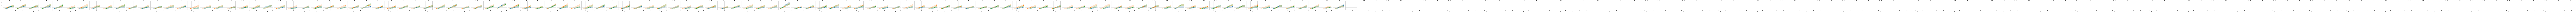

In [33]:
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(combined, hue="type", col="sid", legend_out=False, palette=palette[:4])
    g.map_dataframe(sns.lineplot, x="stage", y='switches')
    g.add_legend()
g.savefig("plots/switches_vs_sid.jpg", dpi=50)

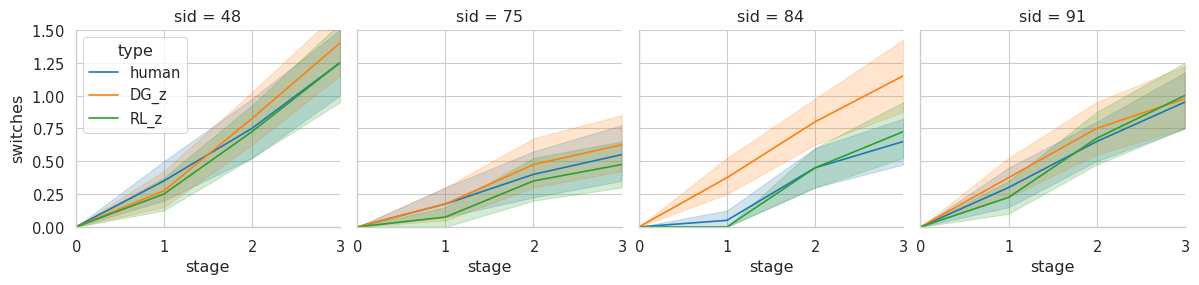

In [47]:
# sid_subset = [6, 16, 69, 75, 120, 132, 187, 40, 48, 74, 8, 84, 180, 91, 96, 113, 116, 121, 156]
# sid_subset = [16, 69, 75, 91, 116, 121, 40, 48, 74, 8, 84, 120]
sid_subset = [48, 91, 75, 84]
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(combined.query("sid==@sid_subset"), hue="type", col="sid", legend_out=False, palette=palette[:4])
    g.map_dataframe(sns.lineplot, x="stage", y='switches')
    g.add_legend()
    for ax in g.axes.flat:
        ax.set_xlim(0, 3)
        ax.set_xticks([0,1,2,3])
        ax.set_ylim(0, 1.5)
g.savefig("plots/switches_vs_subset.jpg", dpi=200)

# Run all models for one SID, varying one parameter

In [67]:
def run_and_get_switches(model_type, sid, z, alpha, beta, lambd=0, seed=0):
    human = pd.read_pickle(f"data/jiang.pkl").query("sid==@sid")
    trials = human['trial'].unique()
    stages = human['stage'].unique()
    rng = np.random.RandomState(seed=seed)
    columns = ['type', 'sid', 'z', 'alpha', 'beta', 'trial', 'stage', 'switches']
    dfs = []
    print(f"model type {model_type}, z {z}, alpha {alpha}, beta {beta}")
    if model_type=='RL_z':
        params = [alpha, z, beta]
    if model_type=='DG_z':
        params = [z, beta]
    # NEF models must pre-run and save data before get_expectations_jiang can retrieve them
    if model_type=='NEF_RL':
        params = [beta]
        data = run_RL("jiang", sid, alpha=alpha, z=z, lambd=lambd)
    if model_type=='NEF_WM':
        params = [beta]
        data = run_WM("jiang", sid, alpha=alpha, z=z, lambd=lambd)
    for trial in trials:
        A_old = 0
        switches = 0
        for stage in stages:
            if model_type=='human':
                A = human.query("trial==@trial & stage==@stage")['action'].unique()[0]
            else:
                expectation = get_expectations_jiang(model_type, params, sid, trial, stage)
                prob = scipy.special.expit(beta*expectation)
                A = 1 if rng.uniform(0,1) < prob else -1
            if stage>0 and A!=A_old:
                switches += 1
            dfs.append(pd.DataFrame([[model_type, sid, z, alpha, beta, trial, stage, switches]], columns=columns))
            A_old = A
    switch_data = pd.concat(dfs, ignore_index=True)
    return switch_data

In [75]:
sid = 91
z = 0.2
alpha = 0.2
beta = 5
dfs = []
for beta in [0.5, 2, 8]:
    dfs.append(run_and_get_switches("human", sid, z, alpha, beta))
    dfs.append(run_and_get_switches("DG_z", sid, z, alpha, beta))
    dfs.append(run_and_get_switches("RL_z", sid, z, alpha, beta))
    dfs.append(run_and_get_switches("NEF_RL", sid, z, alpha, beta))
    dfs.append(run_and_get_switches("NEF_WM", sid, z, alpha, beta))

model type human, z 0.2, alpha 0.2, beta 0.5
model type DG_z, z 0.2, alpha 0.2, beta 0.5
model type RL_z, z 0.2, alpha 0.2, beta 0.5
model type NEF_RL, z 0.2, alpha 0.2, beta 0.5
sid 91, trial 1
sid 91, trial 2
sid 91, trial 3
sid 91, trial 4
sid 91, trial 5
sid 91, trial 6
sid 91, trial 7
sid 91, trial 8
sid 91, trial 9
sid 91, trial 10
sid 91, trial 11
sid 91, trial 12
sid 91, trial 13
sid 91, trial 14
sid 91, trial 15
sid 91, trial 16
sid 91, trial 17
sid 91, trial 18
sid 91, trial 19
sid 91, trial 20
sid 91, trial 21
sid 91, trial 22
sid 91, trial 23
sid 91, trial 24
sid 91, trial 25
sid 91, trial 26
sid 91, trial 27
sid 91, trial 28
sid 91, trial 29
sid 91, trial 30
sid 91, trial 31
sid 91, trial 32
sid 91, trial 33
sid 91, trial 34
sid 91, trial 35
sid 91, trial 36
sid 91, trial 37
sid 91, trial 38
sid 91, trial 39
sid 91, trial 40
model type NEF_WM, z 0.2, alpha 0.2, beta 0.5
sid 91, trial 1
sid 91, trial 2
sid 91, trial 3
sid 91, trial 4
sid 91, trial 5
sid 91, trial 6
sid 91, 

In [63]:
human['z'] = 'human'
combined = pd.concat([human, dgz, rlz, nefrl, nefwm], ignore_index=True)

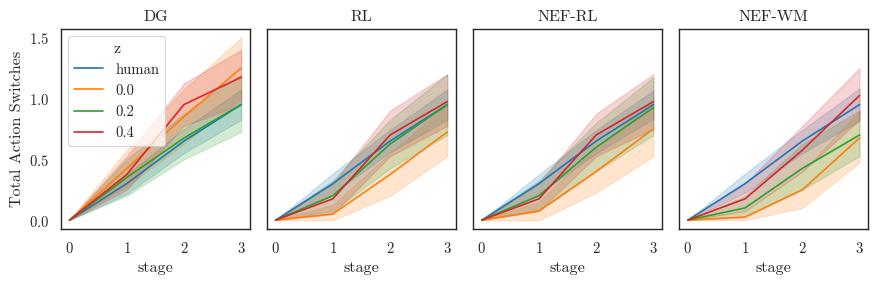

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(9, 3), sharex=True, sharey=True)
dg_query = ['human', 'DG_z']
rl_query = ['human', 'RL_z']
nefrl_query = ['human', 'NEF_RL']
nefwm_query = ['human', 'NEF_WM']
sns.lineplot(combined.query("type==@dg_query"), x='stage', y='switches', hue='z', ax=axes[0], palette=palette[:4])
sns.lineplot(combined.query("type==@rl_query"), x='stage', y='switches', hue='z', ax=axes[1], palette=palette[:4])
sns.lineplot(combined.query("type==@nefrl_query"), x='stage', y='switches', hue='z', ax=axes[2], palette=palette[:4])
sns.lineplot(combined.query("type==@nefwm_query"), x='stage', y='switches', hue='z', ax=axes[3], palette=palette[:4])
axes[0].set(title='DG', ylabel='Total Action Switches', xticks=[0,1,2,3])
axes[1].set(title='RL')
axes[2].set(title='NEF-RL')
axes[3].set(title='NEF-WM')
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/z_demo_all_model_types.jpg", dpi=600)

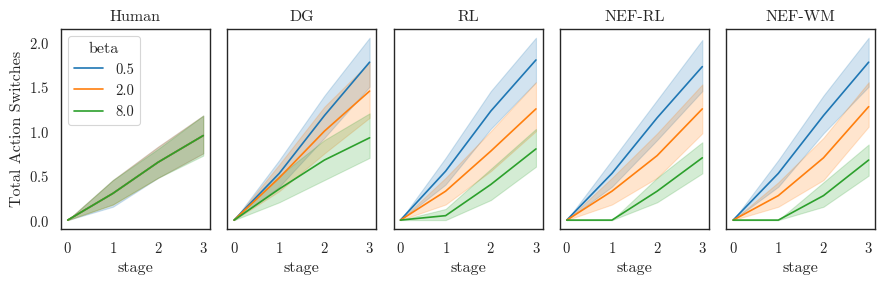

In [76]:
human['beta'] = 'human'
combined = pd.concat(dfs, ignore_index=True)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(9, 3), sharex=True, sharey=True)
sns.lineplot(combined.query("type=='human'"), x='stage', y='switches', hue='beta', ax=axes[0], palette=palette[:3])
sns.lineplot(combined.query("type=='DG_z'"), x='stage', y='switches', hue='beta', ax=axes[1], palette=palette[:3])
sns.lineplot(combined.query("type=='RL_z'"), x='stage', y='switches', hue='beta', ax=axes[2], palette=palette[:3])
sns.lineplot(combined.query("type=='NEF_RL'"), x='stage', y='switches', hue='beta', ax=axes[3], palette=palette[:3])
sns.lineplot(combined.query("type=='NEF_WM'"), x='stage', y='switches', hue='beta', ax=axes[4], palette=palette[:3])
axes[0].set(title='Human', ylabel='Total Action Switches', xticks=[0,1,2,3])
axes[1].set(title='DG')
axes[2].set(title='RL')
axes[3].set(title='NEF-RL')
axes[4].set(title='NEF-WM')
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
axes[4].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/beta_demo_all_model_types.jpg", dpi=600)